# Batch correction

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: surface-protein-batch-correction-key-takeaway-1
:link-type: ref
Due to pronounced batch effects in ADT data, methods like Harmony or scVI, originally designed for transcriptomics data, are recommended for batch correction, as they effectively integrate samples and maintain cell type separation.
:::

```

``````{dropdown} <i class="fa-solid fa-gear"></i>&nbsp;&nbsp;&nbsp;Environment setup
`````{tab-set}
   
````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} surface_protein.yml
:language: yaml
```
````

`````
``````

(surface-protein-batch-correction-key-takeaway-1)=
## Motivation

As could be seen for our earlier visualized ADT data, batch effects between samples are very pronounced.
Hence, batch correction to mitigate this effect is required.
Generally, no purpose build methods for the batch correction of ADT data have been developed, and we therefore suggest applying methods designed for transcriptomics data to ADT data.

## Environment setup

In [1]:
import harmonypy as hm
import muon as mu
import numpy as np
import pooch
import scanpy as sc
import seaborn as sns

# setting visualization parameters
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

## Loading the data

In [2]:
cite_xdbt = pooch.retrieve(
    url="https://figshare.com/ndownloader/files/41452434",
    fname="cite_doublet_removal_xdbt.h5mu",
    path=".",
    known_hash=None,
    progressbar=True,
)

In [3]:
mdata = mu.read("cite_doublet_removal_xdbt.h5mu")

It is not yet clear which batch effect correction works best for ADT data. For general purposes we recommend scVI {cite}`sp:Lopez2018` or Harmony {cite}`Korsunsky2019` to perform batch correction of the data due to their robust performance on scRNA-seq data.

## Harmony

In [4]:
ho = hm.run_harmony(mdata["prot"].X, mdata["prot"].obs, ["donor"])

2023-10-05 14:42:07,939 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-05 14:42:57,421 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-05 14:42:58,062 - harmonypy - INFO - Iteration 1 of 10
2023-10-05 14:43:56,002 - harmonypy - INFO - Iteration 2 of 10
2023-10-05 14:44:55,510 - harmonypy - INFO - Iteration 3 of 10
2023-10-05 14:45:50,797 - harmonypy - INFO - Iteration 4 of 10
2023-10-05 14:46:48,891 - harmonypy - INFO - Iteration 5 of 10
2023-10-05 14:47:51,682 - harmonypy - INFO - Iteration 6 of 10
2023-10-05 14:48:57,953 - harmonypy - INFO - Iteration 7 of 10
2023-10-05 14:49:57,224 - harmonypy - INFO - Iteration 8 of 10
2023-10-05 14:50:43,659 - harmonypy - INFO - Iteration 9 of 10
2023-10-05 14:51:20,036 - harmonypy - INFO - Iteration 10 of 10
2023-10-05 14:52:39,501 - harmonypy - INFO - Converged after 10 iterations


In [5]:
pc_std = np.std(ho.Z_corr, axis=1).tolist()

<Axes: >

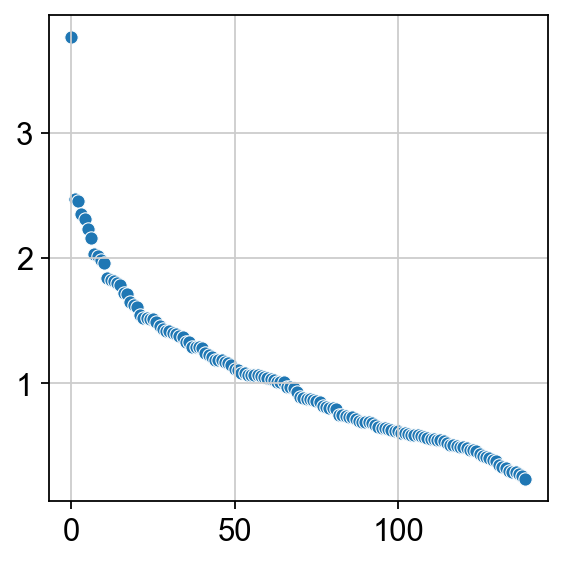

In [6]:
sns.scatterplot(x=range(0, len(pc_std)), y=sorted(pc_std, reverse=True))

In [7]:
mdata["prot"].obsm["X_pcahm"] = ho.Z_corr.transpose()

In [8]:
mdata["prot"].obsm

AxisArrays with keys: X_pcahm

In [9]:
sc.pp.neighbors(mdata["prot"], n_pcs=30, use_rep="X_pcahm")
sc.tl.umap(mdata["prot"])

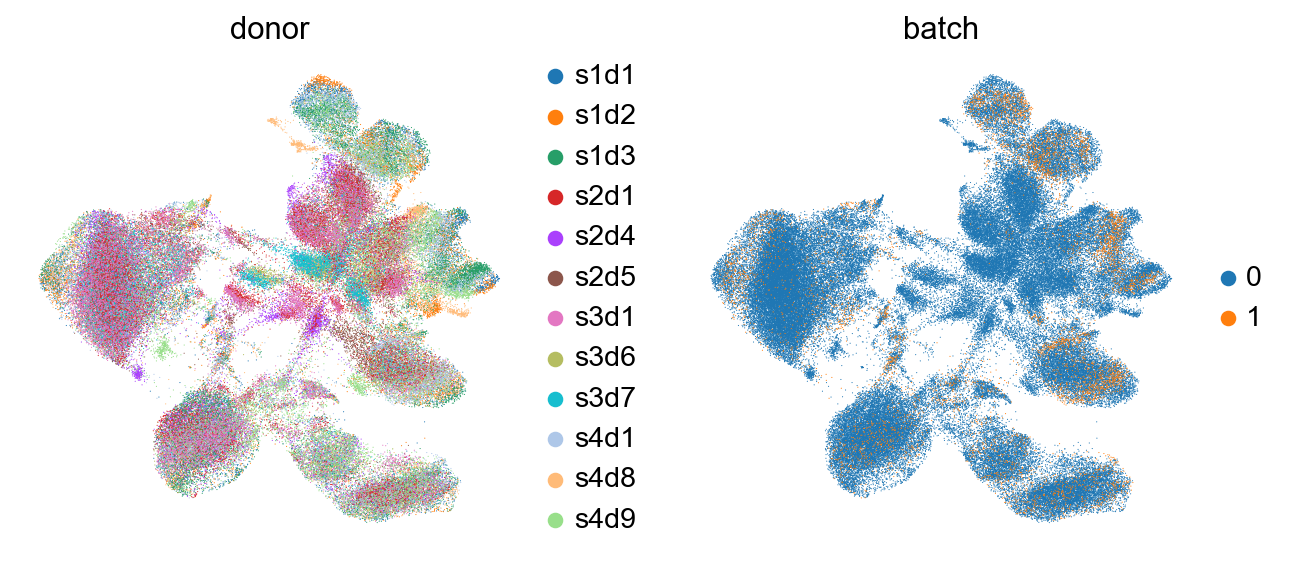

In [10]:
sc.pl.umap(mdata["prot"], color=["donor", "batch"])

As we can see here, the cells of different donors are much more intermixed in the embedding than before.

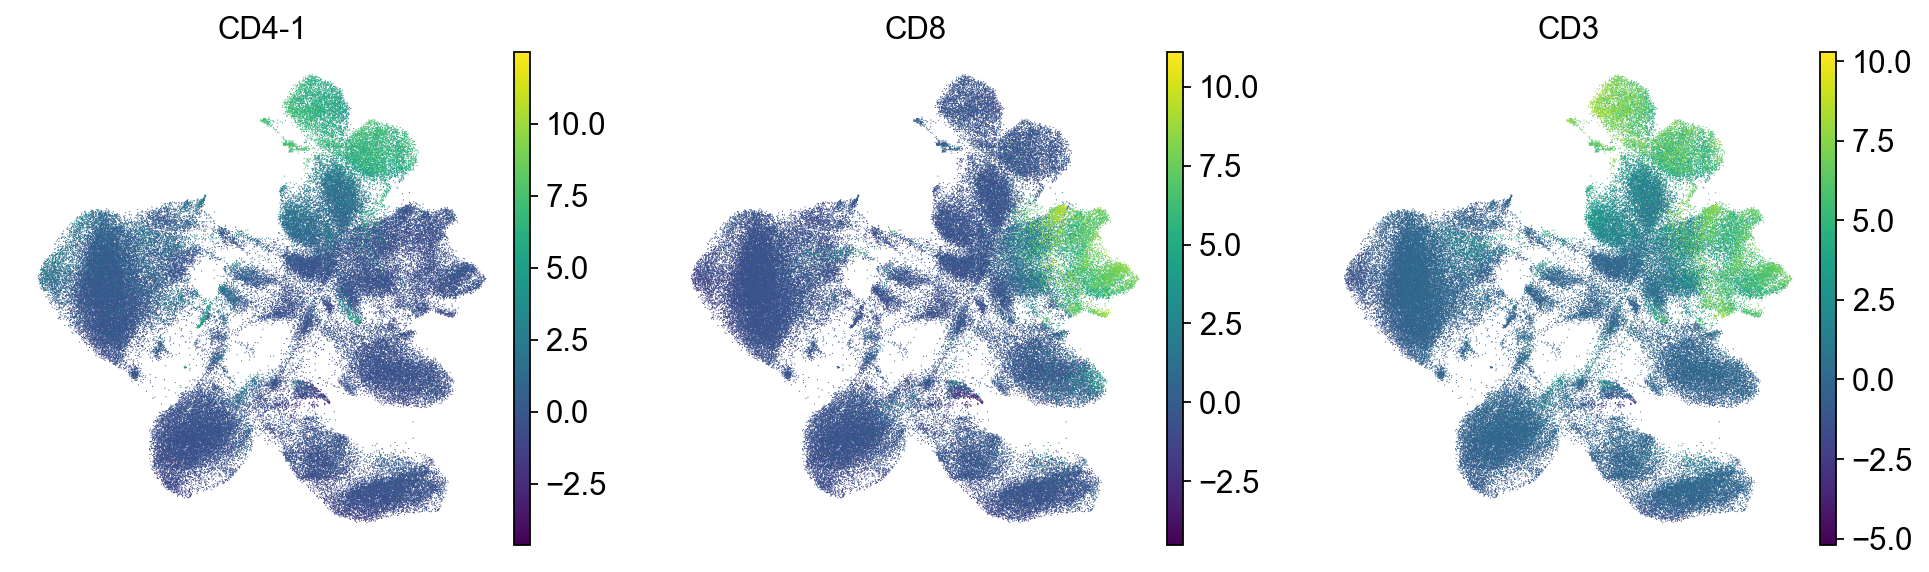

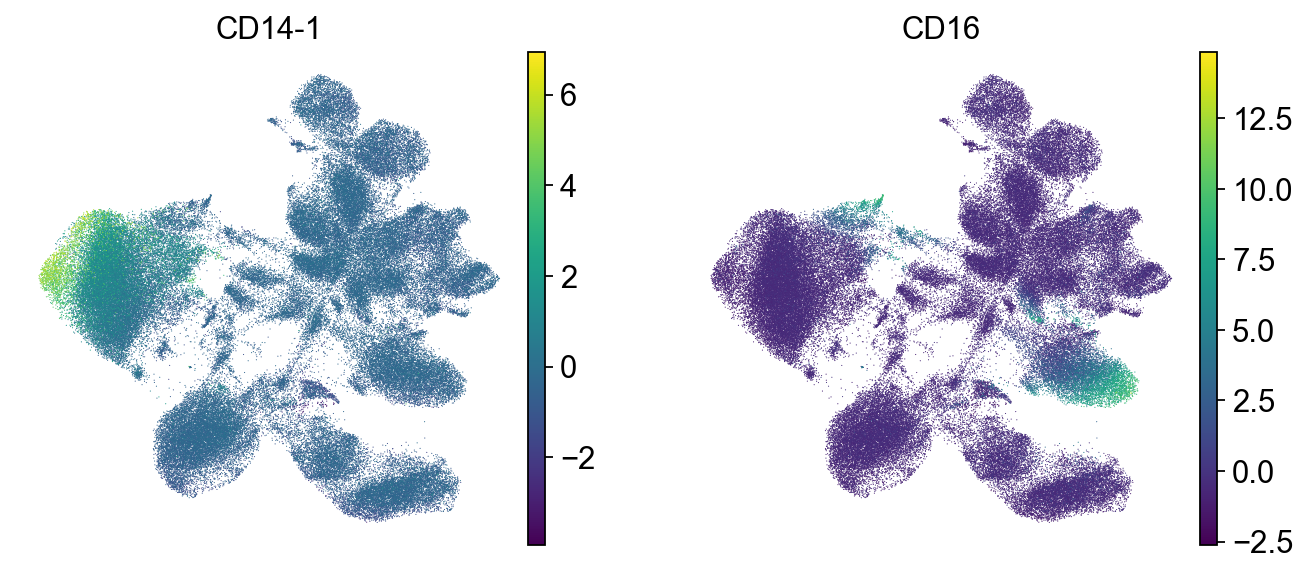

In [11]:
sc.pl.umap(mdata["prot"], color=["CD4-1", "CD8", "CD3"])
sc.pl.umap(mdata["prot"], color=["CD14-1", "CD16"])

We check the expression of a few marker genes to confirm that separate cell types are still separate from each other. We can see that T cells still form a separate population that is further split into CD4 and CD8 T cells.

In following steps, you can now go ahead and cluster and annotate the cells in a similar process as it is described in the annotation chapter[LINK].
Here, we have only used the ADT part of the data and thus lost all of the information contained in the RNA part of the study.
In other chapters, we will explore how you can make use of both modalities jointly, which allows for a more detailed cell type annotation for example.

In [12]:
mdata

MuData object with n_obs × n_vars = 119837 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	119837 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	119837 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors', 'neighbors', 'umap', 'donor_colors', 'batch_colors'
      obsm:	'X_pcahm', 'X_umap'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

In [13]:
mdata.write("cite_batch_correction.h5mu")

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: sp
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Daniel Strobl
* Ciro Ramírez-Suástegui

### Reviewers

* Lukas Heumos
* Anna Schaar